In [1]:
import sys
sys.path.append('..')
import umbrella_mesh
import linkage_vis
import load_jsondata
from configuration import *
from visualization_helper import *

In [2]:
import numpy as np

In [3]:
sys.path.append('../UmbrellaGen')
import grid_gen

### Define the grid dimensions and Umbrella Valence you want

In [4]:
# please make sure rows anx cols are >=2
rows = 10
cols = 5 # one col is two element : /\\/

In [5]:
degree = 3 # TriUmbrellas
numUmbrellas = (rows * 2) * cols

### Define your favorite height, material and cross-section function! Umbrellas are sequenced row-wise if you use the grid

In [6]:
def myHeightFunc(numUmbrellas): 
    heights = [1] * numUmbrellas # Scale Factor of heights. Set minHeight to your desired minimum absolute height.
    for uid in range(numUmbrellas):
        # heights[uid] += (0.1 * uid**1.6 + 0.1 *(numUmbrellas - 1 - uid)**1.6)
        heights[uid] += (0.01 * uid**2 + 0.01 *(numUmbrellas - 1 - uid)**2)
    heights = [h/min(heights) for h in heights]
    return heights

In [7]:
# print(f"There is {numUmbrellas} cells with respective heights:\n{myHeightFunc(numUmbrellas)}")

### Compute Geometry with Regular Grid

In [8]:
# The height function is a scaling function relative to the minHeight
minHeight = 64
grid_gen.genUmbrellaWithHeights(degree, rows, cols, height_scales = [1]*numUmbrellas, minHeight = minHeight) # constant height
# grid_gen.genUmbrellaWithHeights(degree, rows, cols, height_scales = myHeightFunc(numUmbrellas),minHeight = minHeight)

### Initialization of Umbrella Class

In [9]:
name = 'grid_dump'
input_path = '../UmbrellaGen/{}.json.gz'.format(name)
io, input_data, target_mesh, curr_um, plate_thickness_scaled, target_height_multiplier = parse_input(input_path, handleBoundary = False, isHex = (degree == 6), use_target_surface = False)
# Can set use_target_surface = True to add target_mesh to the curr_um class for target attraction during deployment as well as inverse design

### Undeployed Schema

In [10]:
import matplotlib.pyplot as plt

In [11]:
nb_cell = curr_um.numUmbrellas()
center_position = np.zeros([nb_cell, 3])
for i in range(nb_cell):
    top_idx = curr_um.getUmbrellaCenterJi(i, 0)
    center_position[i] = curr_um.joint(top_idx).position

# [RQ] what about others second param's values (1 is for bottom, but what about 2,3,4)
# for i in range(10000):
#     print(curr_um.getUmbrellaCenterJi(0, i))

vertices = input_data['base_mesh_v']
edge = np.roll(np.insert(input_data['base_mesh_f'], 0, input_data['base_mesh_f'][:,0], axis=1), -1, axis=1)

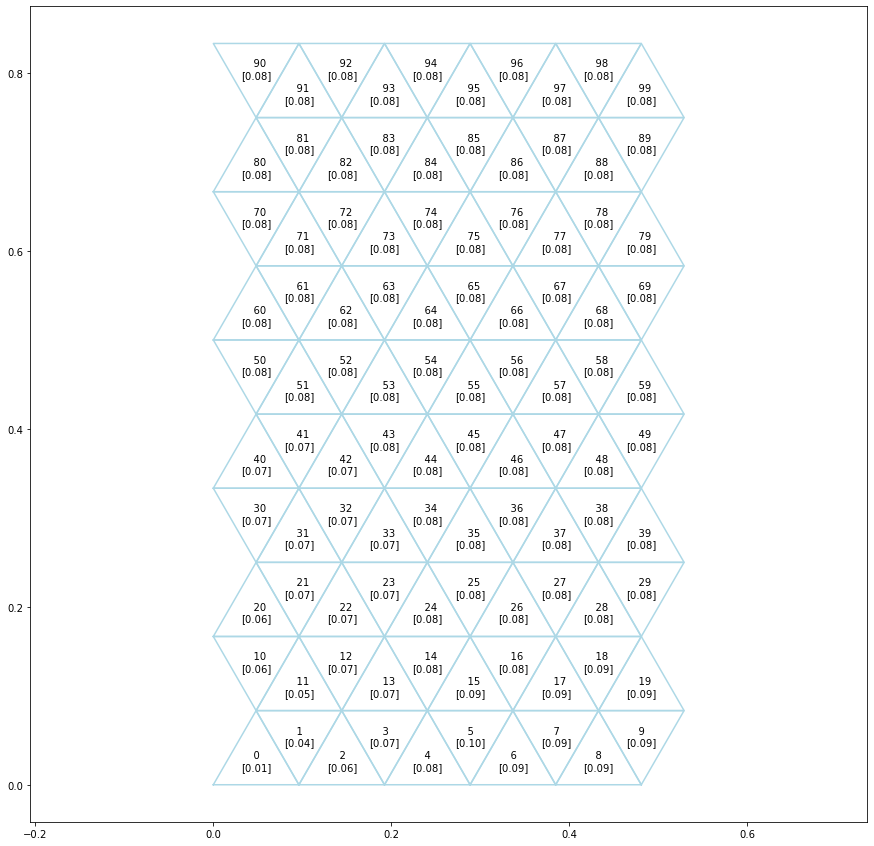

In [27]:
fig = plt.figure(figsize=(15, 15))
# plt.scatter(center_position[:, 0], center_position[:, 1], s=5, color='blue')
for i, ([x,y,z], h) in enumerate(zip(center_position, curr_um.umbrellaHeights)):
    plt.annotate(f'{f"{i}".center(10)}\n[{h:.2f}]', (x,y), xytext=(-15,-10), textcoords='offset points', color='black') # also plot the height
    # plt.annotate(f'{i}', (x,y), xytext=(0,0), textcoords='offset points', color='black')
for e in vertices[edge]:
    plt.plot(e[:, 0], e[:, 1], color="lightblue")
plt.axis('equal')
plt.show()

### 3D Structure

In [13]:
rod_colors = get_color_field(curr_um, input_data, uidBased = False) 
lview = linkage_vis.LinkageViewer(curr_um, width=800, height=600)
lview.update(scalarField = rod_colors)
lview.show()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='#999999', position=(0…

### Deploy umbrellaMesh - Go through configuration.py to get some idea about deployment hyper-params. It's okay if you do not understand everything there

In [14]:
print(f"\
PLATE CHARACTERISTIQUES:\n\
\tplate thickness   : {input_data['thickness']}\n\
\tplate edge length : {input_data['plate_edge_length']}")

PLATE CHARACTERISTIQUES:
	plate thickness   : 0.009622702486524373
	plate edge length : 0.09622702486524373


### Set Free Cells

In [15]:
activated_cell = 5 #
unactivated_cells = [i for i in range(1, activated_cell)] + [i for i in range(activated_cell+1, curr_um.numUmbrellas())]
# unactivated_cells = []
# unactivated_cells = [i for i in range(curr_um.numUmbrellas())] # none activated, but still move... ?

In [16]:
# =====
# 0 : not activated (height is not arbitrary)
# 1 : activated
weights_per_cell = np.ones(curr_um.numUmbrellas())
weights_per_cell[unactivated_cells] = 0
dep_factors = np.logspace(-2, 0, 3) # [RK] deployent steps ?
dep_weights = np.einsum('i, j -> ij', dep_factors, weights_per_cell)

### Set Deployed Heights

In [17]:
#                idx, height
target_height = [( activated_cell, 10),
                 ( 1, 1)]

In [18]:
# =====
# 0 means superpoition of plate | [RQ] should we consider this value for unactivated plate ??
# 1 means plate are in contact (== default value ==)
# higher value are plate's thickness multiple
target_height_multiplier = np.ones(curr_um.numUmbrellas())
for idx,h in target_height:
    target_height_multiplier[idx] = h

if (((target_height_multiplier)[unactivated_cells] != 1).any()):
    print(f"some free cells ({' '.join(map(str, unactivated_cells))}) have a target height, which will be violated")

In [19]:
success, eqays = deploy_umbrella_pin_rigid_motion(curr_um,
                                                  plate_thickness_scaled,
                                                  target_height_multiplier,
                                                  lview, 
                                                  rod_colors,
                                                  analysis = True,
                                                  dep_weights=dep_weights)
print("success : ", success)
# line 109 : why +6 in fixedVars
# line 121 : why if(i%1==0) ? : always true

success :  True


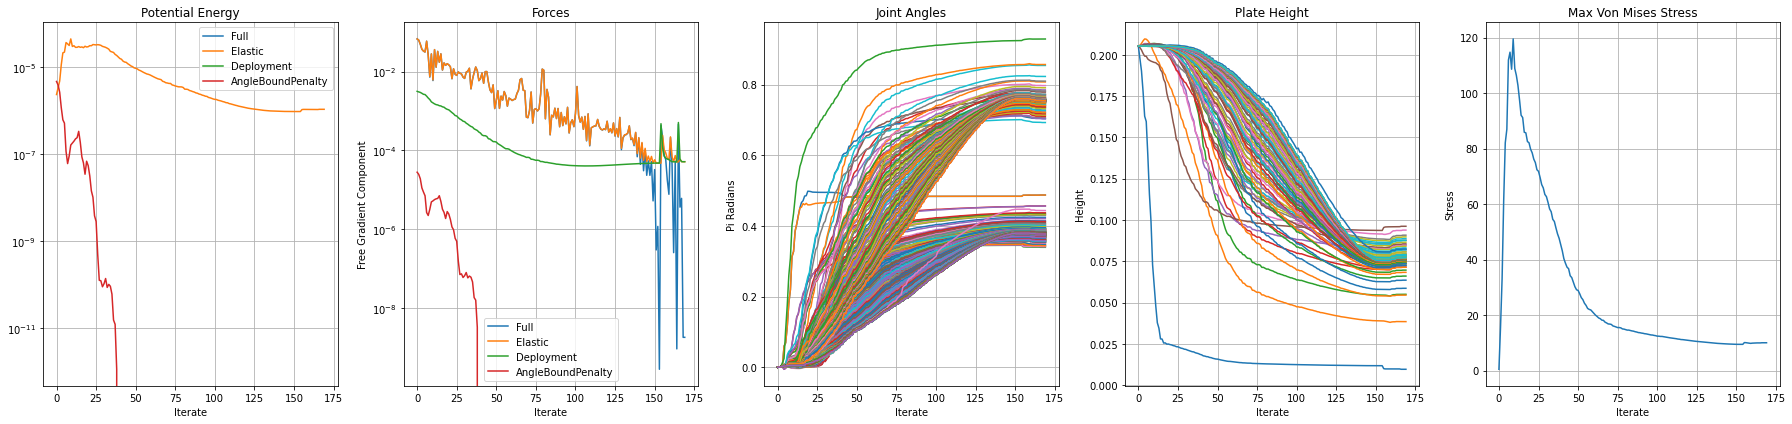

In [20]:
eqays.plot()
# [RK] any units ?

## Stress Visualization

In [21]:
stresses = np.array(curr_um.maxVonMisesStresses())
for sid in range(curr_um.numSegments()):
    seg = curr_um.segment(sid)
    if seg.segmentType() == umbrella_mesh.SegmentType.Plate:
        stresses[sid] *= 0

In [22]:
stresses.shape, np.array(curr_um.maxVonMisesStresses()).shape

((1140, 11), (1140, 11))

In [23]:
sview = linkage_vis.LinkageViewer(curr_um, width=800, height=600)
# sview.update(scalarField = stresses.tolist())
sview.update(scalarField = curr_um.maxVonMisesStresses())
# sview.update(scalarField = curr_um.maxBendingStresses())
# sview.update(scalarField = curr_um.twistingStresses())
sview.show()
# is it possible to scale color without plate stresses ?

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='#999999', position=(0…

In [24]:
sigma_vm = np.array(curr_um.maxVonMisesStresses())
sigma_vm.max(), sigma_vm.min()
# [RK] max value is not equal to the max value in plot

(9.999245579668639, 3.1086244689504383e-12)

In [25]:
sigma_bending = np.array(curr_um.maxBendingStresses())
sigma_bending.max(), sigma_bending.min()

(9.838238499072851, 0.0)

In [26]:
'''
all heights are 1:
- constraints at extrimity... ?
- two curves tendencies in `joint angles`

central and extrimities heights fixed:
- "compensation curves", why ?


- why minHeight is 64 ?
'''

'\nall heights are 1:\n- constraints at extrimity... ?\n- two curves tendencies in `joint angles`\n\ncentral and extrimities heights fixed:\n- "compensation curves", why ?\n\n\n- why minHeight is 64 ?\n'

In [28]:
import pickle, gzip
pickle.dump(curr_um, gzip.open('my_dump.json.gz', 'w'))

In [ ]:
load_um = pickle.load(gzip.open('my_dump.json.gz', 'r'))